<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

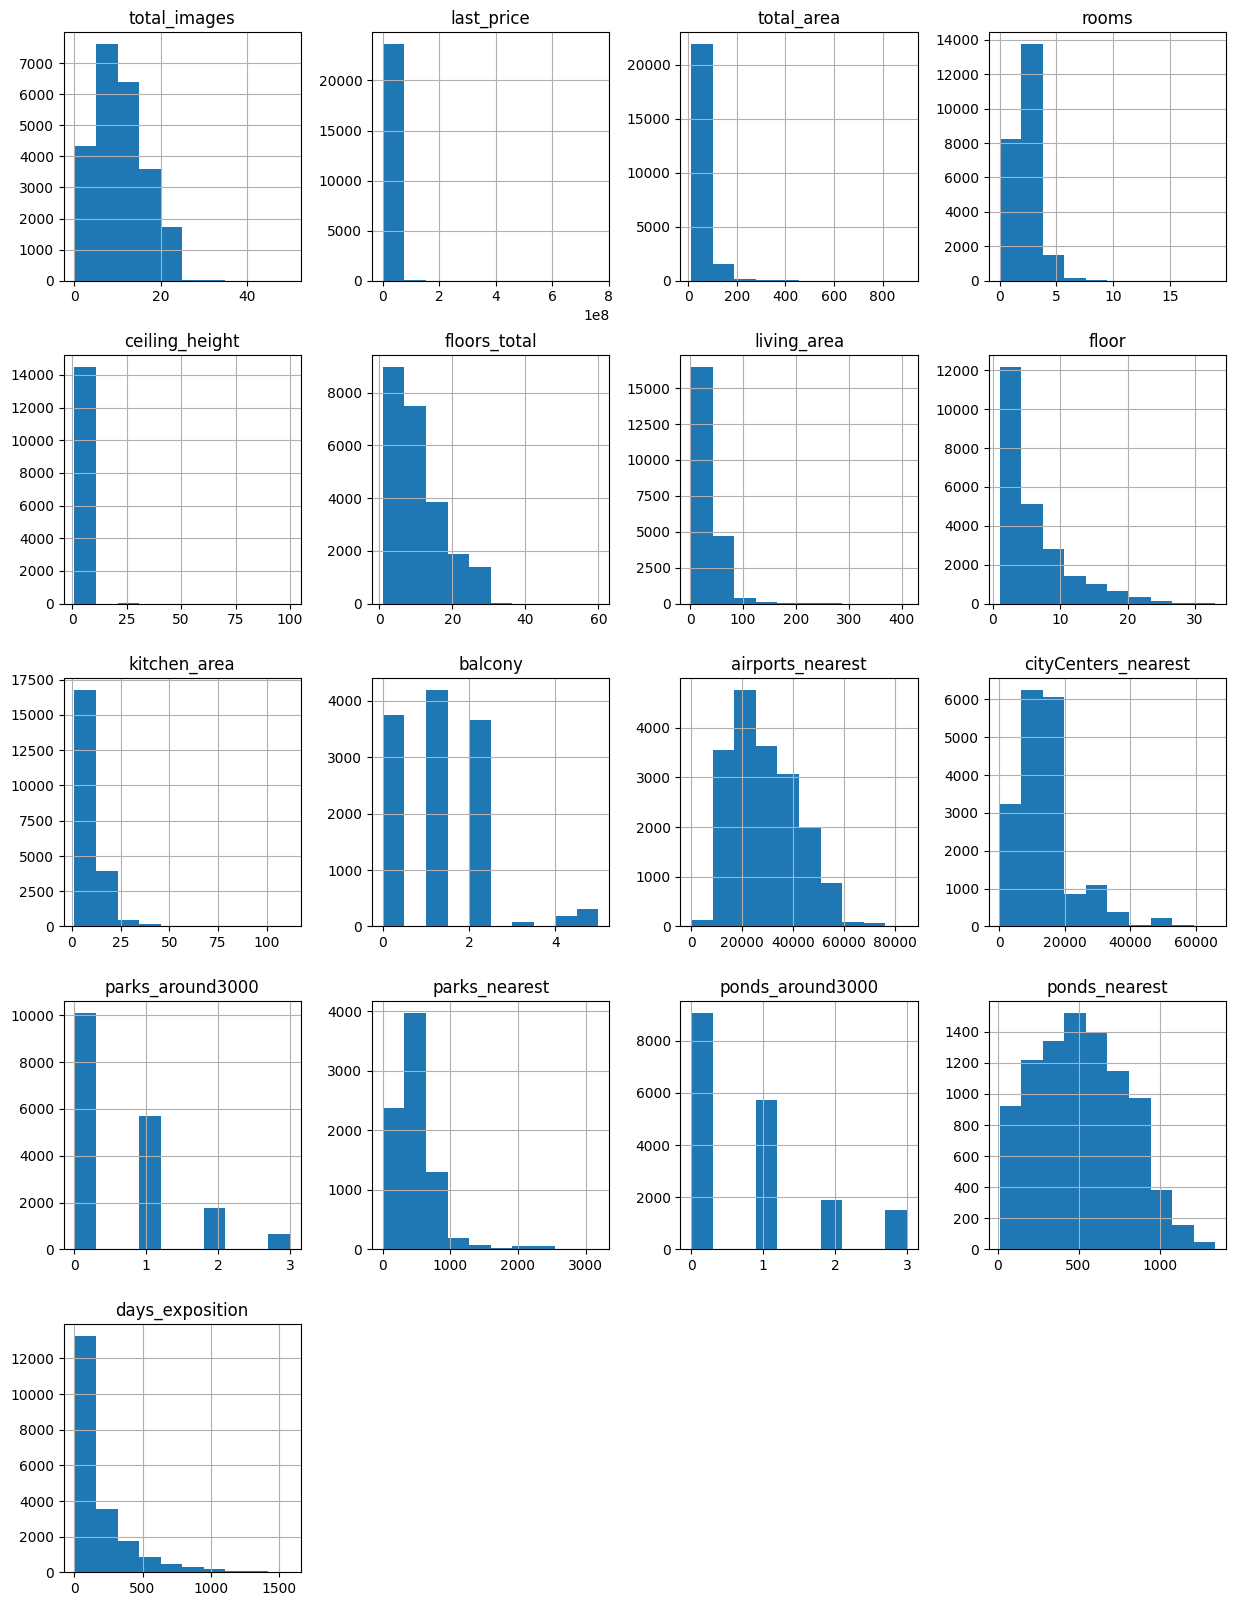

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./datasets/real_estate_data.csv', sep='\t')
data.info()
data.hist(figsize=(15, 20))
data_temp = data  # сохраним на всякий случай
plt.show()

### Выполняем предобработку данных
#### Замена пропущенных значений

__Количественные параметры квартир 

- Заменяем на медианные значения (площади, высота потолков)  для исключения влияния выбросов

- Отсутствующие балконы = 0  у некоторых квартир нет балконов

- Отсутствующие указания количества этажей = 1  в одноэтажном доме нет смысла, так же как и для частного дома где все этажи есть

- Наличие аэропортов, центров, парков и прудов = 0   нет такого вблизи

__заполнение пропусков с изменением типов:

- Этажность строения в целочисленный тип,  при пропуске = 1  этаж - натуральное число, 1 этаж точно есть, то же - если дом частный

- Аппартаменты или нет - в логический тип, пропущенные = 0  "да" или "нет", гораздо чаще "нет"

- Дней с выставления - в целый тип, пропущенные = 1  если объявление есть - 1 день точно


In [2]:
median_ceiling_height = data['ceiling_height'].median()
median_living_area = data['living_area'].median()
median_kitchen_area = data['kitchen_area'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(median_ceiling_height)
data['living_area'] = data['living_area'].fillna(median_living_area)
data['kitchen_area'] = data['kitchen_area'].fillna(median_kitchen_area)
data['balcony'] = data['balcony'].fillna(0)
to_zero_nearests = ['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']
for param in (to_zero_nearests):
    data[param] = data[param].fillna(0)
data['floors_total'] = pd.to_numeric(data['floors_total']).fillna(1)
data['is_apartment'] = data['is_apartment'].astype('bool').fillna(0)
data['days_exposition'] = pd.to_numeric(data['days_exposition']).fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

#### Обрабатываем некорректные названия

In [3]:
# data['locality_name'].duplicated().sum()
# data['locality_name'].value_counts()
# data['locality_name'].unique()

def clean_locality(place):
    if isinstance(place, str) and place != '':
        return place.split()[-1]  # Берем последнее слово
    return "None"  # Возвращаем NaN для нестроковых или пустых значений

data['clean_locality_name'] = data['locality_name'].apply(clean_locality)
print(data['clean_locality_name'].head(20))

0     Санкт-Петербург
1              Шушары
2     Санкт-Петербург
3     Санкт-Петербург
4     Санкт-Петербург
5             Янино-1
6           Парголово
7     Санкт-Петербург
8              Мурино
9     Санкт-Петербург
10    Санкт-Петербург
11          Ломоносов
12          Сертолово
13           Петергоф
14             Пушкин
15    Санкт-Петербург
16    Санкт-Петербург
17    Санкт-Петербург
18    Санкт-Петербург
19    Санкт-Петербург
Name: clean_locality_name, dtype: object


### 3 Добавляем новые столбцы

In [4]:
# Adding columns to data

# Цена 1 кв метра - square_meter_price
data['square_meter_price'] = round(data['last_price'] / data['total_area'], 2)

# День недели публикации - week_day_pub, месяц - month, год - year_pub
data['week_day_pub'] = pd.to_datetime(data['first_day_exposition']).dt.weekday

data['month_pub'] = pd.to_datetime(data['first_day_exposition']).dt.month

data['year_pub'] = pd.to_datetime(data['first_day_exposition']).dt.year

# Тип этажа квартиры: floor_type -> 1-й, последний, другой.

def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data['floor_type'] = data.apply(floor_type, axis=1)

# Расстояние до центра города - distance_to_center

data['distance_to_center'] = round(data['cityCenters_nearest'] / 1000)

data.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,clean_locality_name,square_meter_price,week_day_pub,month_pub,year_pub,floor_type,distance_to_center
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,True,...,2.0,755.0,0.0,Санкт-Петербург,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11.0,18.60,1,True,...,0.0,0.0,81.0,Шушары,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5.0,34.30,4,True,...,2.0,574.0,558.0,Санкт-Петербург,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.65,14.0,30.00,9,True,...,3.0,234.0,424.0,Санкт-Петербург,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,True,...,1.0,48.0,121.0,Санкт-Петербург,100000.00,1,6,2018,другой,8.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.40,5,True,...,0.0,0.0,55.0,Янино-1,95065.79,0,9,2018,другой,0.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,2.65,26.0,10.60,6,True,...,0.0,0.0,155.0,Парголово,99195.71,3,11,2017,другой,19.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,2.65,24.0,30.00,22,True,...,0.0,0.0,0.0,Санкт-Петербург,110544.69,3,4,2019,другой,12.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,True,...,0.0,0.0,189.0,Мурино,87454.76,2,5,2018,другой,0.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,True,...,0.0,0.0,289.0,Санкт-Петербург,88524.59,6,2,2017,другой,15.0


<Axes: >

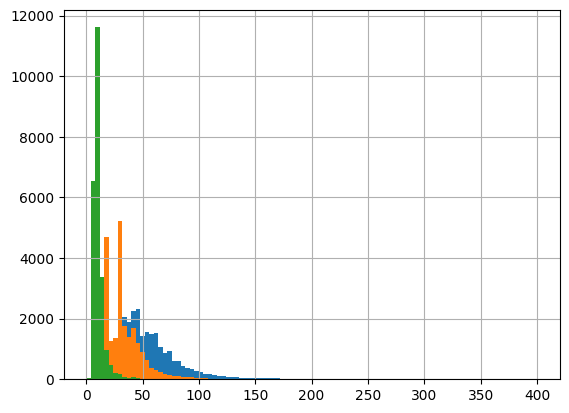

In [5]:
## Построение гистограм
data['total_area'].hist(bins=100, range=(0, 400))
data['living_area'].hist(bins=100, range=(0, 400))
data['kitchen_area'].hist(bins=100, range=(0, 400))


<Axes: >

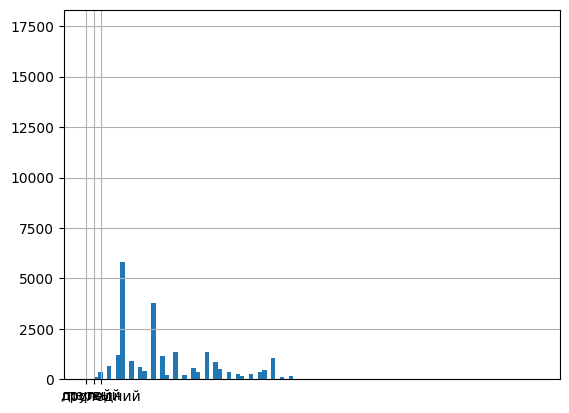

In [6]:
# Построение диграмм. Набор 2 Этажность.

data['floors_total'].hist(bins=100)
data['floor_type'].hist(bins=100)
# data['kitchen_area'].hist(bins=100, range=(0, 400))

<Axes: >

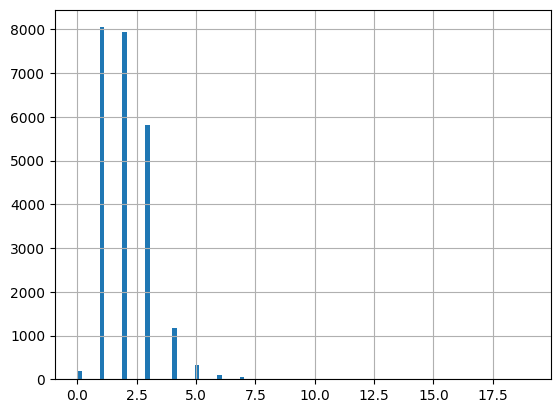

In [7]:
data['rooms'].hist(bins=100)


<Axes: >

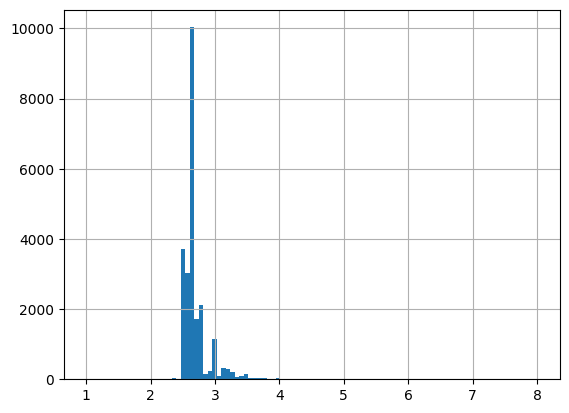

In [8]:
data['ceiling_height'].hist(bins=100, range=(1, 8))


<Axes: >

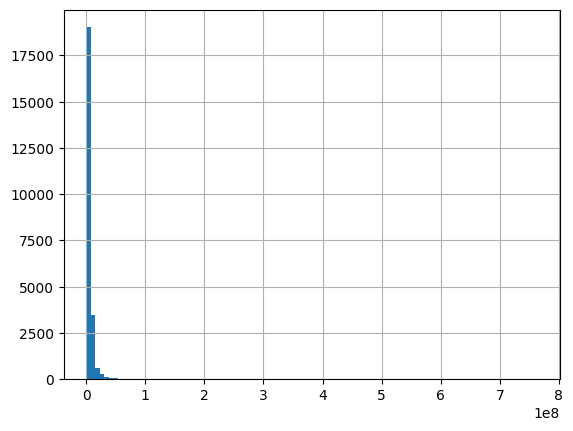

In [9]:
data['last_price'].hist(bins=100)


<Axes: >

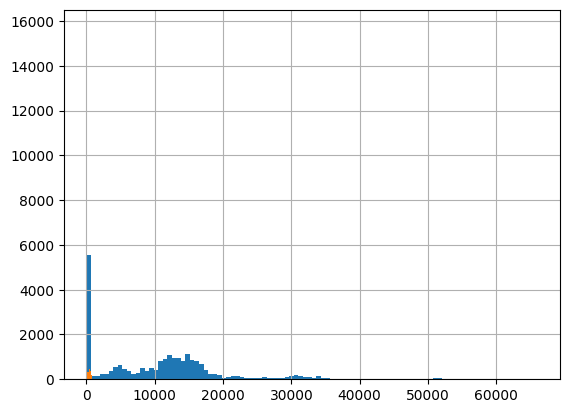

In [10]:
data['cityCenters_nearest'].hist(bins=100)
data['parks_nearest'].hist(bins=100)

74.0 173


<Axes: >

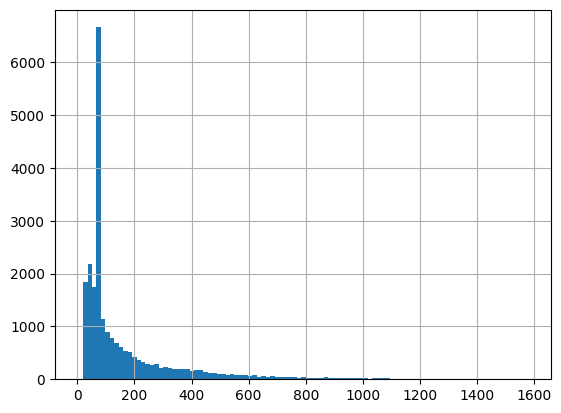

In [28]:
# Как быстро продавались квартиры
data['days_exposition'].hist(bins=100)
medianX = data['days_exposition'].median()
average = data['days_exposition'].mean()
print(medianX, round(average))
# data.loc[data['days_exposition'] < 20, 'days_exposition'] = medianX
data['days_exposition'].unique()
data['days_exposition'].max()
data['days_exposition'].head(30)

# Фильтруем данные, исключая выбросы?
filtered_data = data[(data['days_exposition'] >= 150) & (data['days_exposition'] <= 3)]
filtered_data['days_exposition'].hist(bins=100)